## Configurations

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
import pandas as pd
from scipy.signal import lfilter


def normalize(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))
def decay1(t,A,tau,y0):
    return A*np.exp(-t/tau)+y0
def decay2(t,A1,A2,tau1,tau2,y0):
    return A1*np.exp(-t/tau1)+A2*np.exp(-t/tau2)+y0
def curve_fit_new(f, xdata, ydata,unit_time=50,**kwargs):
    bounds_lim=(0,np.inf)
    if not 'bounds' in kwargs.keys():
        kwargs['bounds']=bounds_lim
    popt, pcov = curve_fit(f, xdata/unit_time, ydata,**kwargs)#,maxfev=100000)
    perr = np.sqrt(np.diag(pcov))
    if f == decay2:
        popt_new = np.concatenate([popt[:2],popt[2:4]*unit_time,popt[4:]])
        perr_new = np.concatenate([perr[:2],perr[2:4]*unit_time,perr[4:]])
        fast_ind = np.argmin(popt_new[2:4])
        slow_ind = np.argmax(popt_new[2:4])
        popt_new = popt_new[[fast_ind,slow_ind,fast_ind+2,slow_ind+2,-1]]
        perr_new = perr_new[[fast_ind,slow_ind,fast_ind+2,slow_ind+2,-1]]
    elif f == decay1:
        popt_new = np.concatenate([popt[:1],popt[1:2]*unit_time,popt[2:]])
        perr_new = np.concatenate([perr[:1],perr[1:2]*unit_time,perr[2:]])
#     print(popt_new)
    return popt_new,perr_new
def plotBigGraphs(which,normalized_list,minor_shift,num_points = 1400,unit_time = 50,cutoff_raw = 70,offsetdiv = 10,pad=2,figsize=(15,5),xrange=(-5,45),
                 linewidth_data=0.5,linewidth_fit=3,yrange=(0.1,5),w_pad=0,h_pad=0):
    if which == 'G':
        minor_shift = [0,0,0,1,0,1,0,0,0,3]
#         normalized_list = normalized_Glist
        bigFigurePath = savePath+'/G_big.png'
        smallFigurePath = savePath+'/G_small.png'
    elif which == 'B':
        minor_shift = [0,0,0,0,0,1,0,0,0,1]
#         normalized_list = normalized_Blist
        bigFigurePath = savePath+'/B_big.png'
        smallFigurePath = savePath+'/B_small.png'
    
    fast_list = []
    slow_list = []
    plt.ioff()
    fig,axs = plt.subplots(2,5,figsize=figsize)
    for ind,normalized in enumerate(normalized_list):
        cutoff = cutoff_raw-minor_shift[ind]
        xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
        ax = axs[ind//5,ind%5]
        popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(normalized)],normalized[cutoff:])
        fast_list.append(np.min(popt_new[2:4]))
        slow_list.append(np.max(popt_new[2:4]))
        ax.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*popt_new)-popt_new[-1]/offsetdiv,color='blue',linewidth=linewidth_fit)
        ax.plot(xlist[:len(normalized)]/1e3,normalized[:]-popt_new[-1]/offsetdiv,'-',linewidth=linewidth_data,color='black',zorder=-9)
        ax.set_yscale('log')
        
#         ax.set_xlim(xlist[0]/1e3,65)
#         ax.set_ylim(7e-2,1.2)

        ax.set_xlim(xrange)
        ax.set_ylim(yrange)
        
#         ax.set_xlabel('Time (µs)')
#         ax.set_ylabel('iMIM-Im (mV)')
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(1.5)
#         ax.xaxis.set_tick_params(width=2,length=5)
#         ax.yaxis.set_tick_params(width=2,length=5)
#         ax.xaxis.set_tick_params(width=2,length=5)
#         ax.yaxis.set_tick_params(which='minor',width=2)
    #     ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
#         ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
#         ax.set_xticks(np.arange(0,70,10))
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_minor_formatter(plt.NullFormatter())

#         ax.set_xticks([])
        
#         ax.tick_params(direction="in",which='both')#, left="off",labelleft="on")
#         ax.tick_params(axis="y",direction="in")
        ax.set_yticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout(pad=pad,w_pad=w_pad,h_pad=h_pad)
    plt.savefig(bigFigurePath)
    print(popt_new)
    return fast_list,slow_list

def plotPos(pos_list,buffer=None,decay=1,log=False,xlim=None,ylim=None,cutoff_raw = 81,offsetdiv=10,expand=1.,minor_shift = [0,0,0,0,0,0,0,0,0,0,0,0,0,],smallWindows=0,pad=1,height=3):
    num_points = 1400
    unit_time = 50
    fast_list = []
    slow_list = []
    fast_A_list = []
    slow_A_list = []
    one_list = []
    one_A_list = []
    one_error_list = []
    fast_error_list = []
    slow_error_list = []
    fig,axs = plt.subplots(1,len(pos_list),figsize=(4*len(pos_list),height))
    print(np.shape(axs))
    for ind,etl in enumerate(pos_list):
        cutoff = cutoff_raw-minor_shift[ind]
        xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
        ax = axs[ind]
        ydata = normalize(etl+1.75*ind)*expand

        if decay == 2:
            popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(ydata)],ydata[cutoff:])
#             print(popt_new)
            fast_ind = np.argmin(popt_new[2:4])
            slow_ind = np.argmax(popt_new[2:4])
            fast_list.append(popt_new[fast_ind+2])
            slow_list.append(popt_new[slow_ind+2])
            fast_A_list.append(popt_new[fast_ind]) 
            slow_A_list.append(popt_new[slow_ind]) 
            fast_error_list.append(perr_new[fast_ind+2])
            slow_error_list.append(perr_new[slow_ind+2])
            fitdata = decay2(xlist[cutoff:len(ydata)],*popt_new)-popt_new[-1]/offsetdiv
            ax.plot(xlist[cutoff:len(ydata)]/1e3,fitdata,color='red',linewidth=2)
        elif decay == 1:
            popt_new,perr_new = curve_fit_new(decay1,xlist[cutoff:len(ydata)],ydata[cutoff:])
#             print(popt_new)
            one_ind = 1
            one_list.append(popt_new[one_ind])
            one_A_list.append(popt_new[0]) 
            fitdata = decay1(xlist[cutoff:len(ydata)],*popt_new)-popt_new[-1]/offsetdiv
            ax.plot(xlist[cutoff:len(ydata)]/1e3,fitdata,color='red',linewidth=2)
            one_error_list.append(perr_new[one_ind])
        ax.plot(xlist[:len(etl)]/1e3,ydata-popt_new[-1]/offsetdiv,color='black',zorder=-9)
        if smallWindows == 0:
            if ind == 0:
                    ax.set_ylabel('iMIM-Im (a.u.)')
            else:
                    ax.get_yaxis().set_ticks([])
            ax.set_xlabel('Time (µs)')
        else:
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        if log == True:
            ax.set_yscale('log')
        if ylim is not None:
            ax.set_ylim(ylim[0],ylim[1])
        if xlim is not None:
            ax.set_xlim(xlim[0],xlim[1])
        else:
            ax.set_xlim(xlist[0]/1e3,65)
        if buffer is not None:
            buffer.append(fitdata)
    plt.tight_layout(pad=pad)
    print(xlist[:len(etl)]/1e3)

    return one_list,fast_list,slow_list,one_error_list,fast_error_list,slow_error_list

'''
Color parts of a line based on its properties, e.g., slope.
https://matplotlib.org/examples/pylab_examples/multicolored_line.html
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm



def plotTwoColors(x,y,color1,color2,boundary_y,linewidth=15,ax=None):
    cmap = ListedColormap([color1,color2])
    norm = BoundaryNorm([-np.inf, boundary_y, np.inf], cmap.N)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(y)
    lc.set_linewidth(linewidth)

#     fig1 = plt.figure()
    if ax==None:
        plt.gca().add_collection(lc)
    else:
        ax.add_collection(lc)
    
def data_lfilter(data,a=1,n=5):
    b=[1/n]*n
    data_filtered = lfilter(b,a,data)
    return data_filtered
def data_avefilter(data,num = 2):
    data_averaged = []
    for ind in range(len(data)):
        if ind>num-1 and ind<len(data)-num:
            data_averaged.append(np.mean(data[ind-num:ind+num+1]))
        else:
            data_averaged.append(data[ind])
    return data_averaged

def data_medianfilter(data,num = 2):
    data_averaged = []
    for ind in range(len(data)):
        if ind>num-1 and ind<len(data)-num:
            data_averaged.append(np.median(data[ind-num:ind+num+1]))
        else:
            data_averaged.append(data[ind])
    return data_averaged

def equidistant(x,y, d, max_l = 1,ratio_figsize=1.):
    '''
    https://nikolasent.github.io/mathematics/algorithms/2017/05/02/Approximate-equidistant-curve-for-polynomials.html
    '''
    x_pol = np.array(x).copy()
    y_pol = np.array(y).copy()
    xrange = len(x_pol)
    yrange = len(y_pol)
    ratio = xrange/yrange
    y_pol *= ratio*ratio_figsize
    x_m = [] # Mid points
    y_m = []
    k_m = []
    # Calculate polints position between given points
    for i in range(len(x_pol)-1):
        y_m.append((y_pol[i+1]-y_pol[i])/2.0+y_pol[i])
        x_m.append((x_pol[i+1]-x_pol[i])/2.0+x_pol[i])
        # Slope of perpendicular lines
        if y_pol[i+1] == y_pol[i] or np.isclose(y_pol[i],y_pol[i+1]): #Avoid division by 0
            k_m.append(1e8) # A vary big number
        else:
            k_m.append(-(x_pol[i+1]-x_pol[i])/(y_pol[i+1]-y_pol[i])) # Slope of a perpendicular
    # Convert arrays into np.arrays
    x_m = np.array(x_m)
    y_m = np.array(y_m)
    k_m = np.array(k_m)
    # Calculate equidistant points
    x_eq = d*np.sqrt(1.0/(1+k_m**2)) # Calculate reference shift dx of the equidistant points
    y_eq = np.zeros_like(x_eq) # Create np.array for y_eq
    if d >= 0: # x positions of the equidistant depends on direction
        for i in range(len(y_m)):
            if k_m[i] < 0: 
                x_eq[i] = x_m[i]-abs(x_eq[i])
            else:
                x_eq[i] = x_m[i]+abs(x_eq[i])
            y_eq[i] = (y_m[i]-k_m[i]*x_m[i])+k_m[i]*x_eq[i]
    else:
        for i in range(len(y_m)):
            if k_m[i] < 0:
                x_eq[i] = x_m[i]+abs(x_eq[i])
            else:
                x_eq[i] = x_m[i]-abs(x_eq[i])
            y_eq[i] = (y_m[i]-k_m[i]*x_m[i])+k_m[i]*x_eq[i]
    return x_eq,y_eq/(ratio*ratio_figsize)

def plot_equidistant(x,y,width,ratio_figsize,ax=None,**kwarg):
    xrange = np.max(x)-np.min(x)
    yrange = np.max(y)-np.min(y)
    # plt.plot(x,y)

    newx,newy = equidistant(x,y,width,
                            ratio_figsize = ratio_figsize)
    newx2,newy2 = equidistant(x,y,-width,ratio_figsize=ratio_figsize)
    if ax==None:
        ax = plt.gca()
    ax.fill(np.concatenate([newx,newx2[::-1]]),np.concatenate([newy,newy2[::-1]]),**kwarg)
#     ax.set_yscale('log')


[1.67690561e+00 6.93636744e-01 7.27456376e+02 2.11056448e+04
 1.02977824e+00]
[1.79089981e+00 9.30503115e-01 5.01212269e+02 1.29805977e+04
 4.52624221e-01]


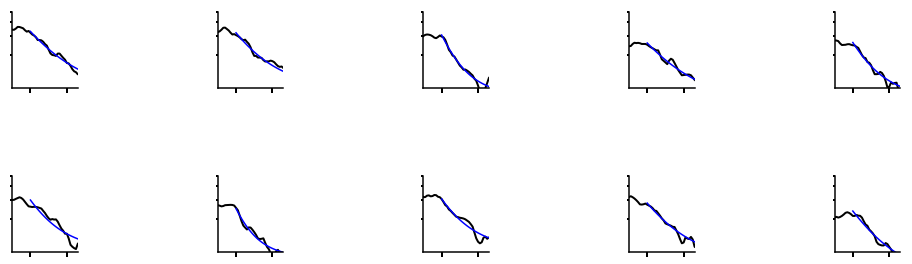

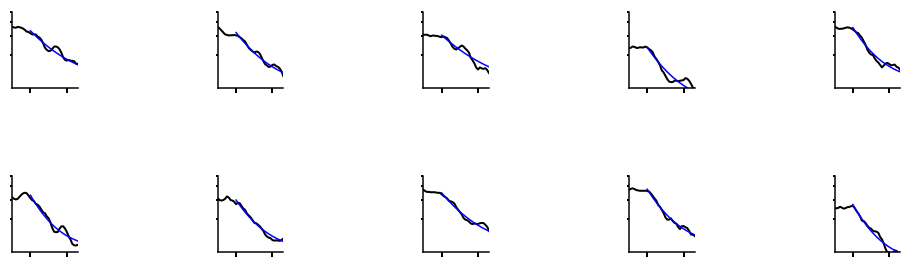

In [194]:
# %matplotlib auto

SMALL_SIZE = 8
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major',size=5,width=2)
plt.rc('ytick.major',size=5,width=2)
plt.rc('xtick.minor',size=2,width=2)
plt.rc('ytick.minor',size=2,width=2)




savePath = "../Perovskite_KaiZhu(2nd_floor)/Sample_201911/1/processFiles/"
B_root = "../Perovskite_KaiZhu(2nd_floor)/Sample_201911/1/20200129_446nm_20_points/Data/"
G_root = B_root
B_files = ["2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B1_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B2_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B3_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B4_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B5_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B6_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B7_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B8_transposed.csv",
          "2020-01-30_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B9_transposed.csv",
          "2020-01-30_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B10_transposed.csv"]
G_files = ["2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G1_again_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G2_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G3_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G4_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G5_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G6_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G7_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G8_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G9_transposed.csv",
          "2020-01-30_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G10_transposed.csv"]

data_Blist = [pd.read_csv(B_root+file,header=None)[0].values for file in B_files]
data_Glist = [pd.read_csv(G_root+file,header=None)[0].values for file in G_files]
normalized_Blist = [normalize(item) for item in data_Blist]
normalized_Glist = [normalize(item) for item in data_Glist]

#minor_shift = [0,0,0,0,0,1,0,0,0,1]
minor_shift = [0,0,0,1,0,1,0,0,0,3]

# fast_Glist,slow_Glist = plotBigGraphs('G',normalized_Glist,minor_shift)
# fast_Blist,slow_Blist = plotBigGraphs('B',normalized_Blist,minor_shift)

data_Glist=np.asarray([data_avefilter(item,num=2) for item in data_Glist])
data_Blist=np.asarray([data_avefilter(item,num=2) for item in data_Blist])

fast_Glist,slow_Glist = plotBigGraphs('G',data_Glist,minor_shift,offsetdiv=1.,figsize=(15,6),pad=7,xrange=(-0.5,1.3),linewidth_data=2,linewidth_fit=1.5,yrange=(1,5),w_pad=10,h_pad=6)
fast_Blist,slow_Blist = plotBigGraphs('B',data_Blist,minor_shift,offsetdiv=1.,figsize=(15,6),pad=7,xrange=(-0.5,1.3),linewidth_data=2,linewidth_fit=1.5,yrange=(1,5),w_pad=10,h_pad=6)
plt.show()



In [101]:
len(data_Glist)

10

t1 Grain: 0.695663312
t1 Boundary: 0.701189351
t2 Grain: 16.741839406000004
t2 Boundary: 16.577018369


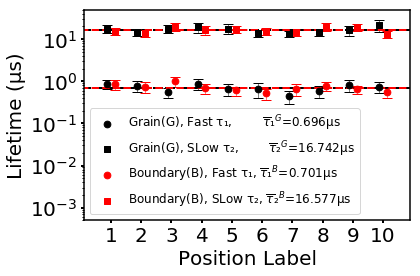

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major',size=3,width=2)
plt.rc('ytick.major',size=3,width=2)
plt.rc('xtick.minor',size=2,width=1)
plt.rc('ytick.minor',size=2,width=1)

t1_G_list = np.asarray([866.66511,773.89004,556.51447,882.48158,644.69493,645.01299,438.60335,598.80665,819.65826,730.30574])/1000
t1_B_list = np.asarray([842.22812,743.47775,997.40317,680.57775,604.59577,513.29562,647.65729,780.53478,645.0389,557.08436])/1000
t2_G_list = np.asarray([17813.18258,14568.61247,17769.69621,19446.6767,17903.719,14174.62262,13554.3532,14978.64816,16057.04112,21151.842])/1000
t2_B_list = np.asarray([15837.84388,13665.93613,19886.85435,16813.93666,17317.41025,15604.54352,14858.42028,19656.09712,18938.22791,13190.91359])/1000
# t1_G_list = np.asarray(fast_Glist)/1000
# t1_B_list = np.asarray(fast_Blist)/1000
# t2_G_list = np.asarray(slow_Glist)/1000
# t2_B_list = np.asarray(slow_Blist)/1000

t1_G_mean = np.mean(t1_G_list)
t1_B_mean = np.mean(t1_B_list)
t2_G_mean = np.mean(t2_G_list)
t2_B_mean = np.mean(t2_B_list)
print("t1 Grain:",t1_G_mean)
print("t1 Boundary:",t1_B_mean)
print("t2 Grain:",t2_G_mean)
print("t2 Boundary:",t2_B_mean)
# t1_G_std = np.std(t1_G_list)
# t1_B_std = np.std(t1_B_list)
# t2_G_std = np.std(t2_G_list)
# t2_B_std = np.std(t2_B_list)
t1_G_std = np.array([70.35679,74.42368,48.80223,84.13497,69.26422,81.72991,48.96266,63.18758,83.93289,70.52462])/1e3
t2_G_std = np.array([1369.13997,975.75943,1350.35693,1764.94823,1484.0215,918.88845,832.21779,953.43973,1345.50963,2220.45955])/1e3
t1_B_std = np.array([77.83112,68.50899,88.94773,61.86313,48.55473,49.44132,67.70574,63.05848,46.50974,52.24646])/1e3
t2_B_std = np.array([980.1255,860.95999,1537.57537,1340.98951,1057.86242,997.69036,998.15669,1393.47919,1194.50137,857.29649])/1e3
# t1_G_errorbar = [[t1_G_mean-t1_G_std/2,t1_G_mean+t1_G_std/2] for item in t1_G_list]
# t2_G_errorbar = [[t2_G_mean-t2_G_std/2,t2_G_mean+t2_G_std/2] for item in t2_G_list]
# t1_B_errorbar = [[t1_B_mean-t1_B_std/2,t1_B_mean+t1_B_std/2] for item in t1_B_list]
# t2_B_errorbar = [[t2_B_mean-t2_B_std/2,t2_B_mean+t2_B_std/2] for item in t2_B_list]
delta = 3
# t1_G_errorbar = [[item-delta*t1_G_std[ind],item+delta*t1_G_std[ind]] for ind,item in enumerate(t1_G_list)]
# t2_G_errorbar = [[item-delta*t2_G_std[ind],item+delta*t2_G_std[ind]] for ind,item in enumerate(t2_G_list)]
# t1_B_errorbar = [[item-delta*t1_B_std[ind],item+delta*t1_B_std[ind]] for ind,item in enumerate(t1_B_list)]
# t2_B_errorbar = [[item-delta*t2_B_std[ind],item+delta*t2_B_std[ind]] for ind,item in enumerate(t2_B_list)]

marker_size = 45

pos_list_G = np.array([1,2,3,4,5,6,7,8,9,10])-0.125
pos_list_B = np.array([1,2,3,4,5,6,7,8,9,10])+0.125
plt.figure()
plt.scatter(pos_list_G,t1_G_list,color='black',s=marker_size,label="Grain(G), Fast τ₁,        $\overline{τ}$₁$^G$="+"{:.3f}µs".format(t1_G_mean),zorder=100)
plt.plot([0,11],[t1_G_mean,t1_G_mean],color = 'black',linestyle='dashed',dashes = (5,1),linewidth=2)

for ind,item in enumerate(t1_G_std):
     plt.errorbar(pos_list_G[ind],t1_G_list[ind],3*t1_G_std[ind],color = 'black',fmt='-_',capsize=5.25,zorder=0,linewidth=0.5,ls='none')
plt.scatter(pos_list_B,t1_B_list,color='red',s=marker_size,label="Boundary(B), Fast τ₁, $\overline{τ}$₁$^B$="+"{:.3f}µs".format(t1_B_mean),zorder=100)        
plt.plot([0,11],[t1_B_mean,t1_B_mean],color = 'red',linestyle='dashed',linewidth=2)
for ind,item in enumerate(t1_B_std):
     plt.errorbar(pos_list_B[ind],t1_B_list[ind],3*t1_B_std[ind],color = 'red',fmt='-_',capsize=5.25,zorder=0,linewidth=0.5,ls='none')
plt.yscale('log')
# plt.plot([1,10])
# plt.ylim(10,5e4)

# plt.figure()
plt.scatter(pos_list_G,t2_G_list,color='black',marker = 's',s=marker_size,label="Grain(G), SLow τ₂,        $\overline{τ}$₂$^G$="+"{:.3f}µs".format(t2_G_mean),zorder=100)
plt.plot([0,11],[t2_G_mean,t2_G_mean],color = 'black',linestyle='dashed',dashes = (5,1),linewidth=2)
for ind,item in enumerate(t2_G_std):
     plt.errorbar(pos_list_G[ind],t2_G_list[ind],3*t2_G_std[ind],color = 'black',fmt='-_',capsize=5.25,zorder=0,linewidth=0.5,ls='none')
plt.scatter(pos_list_B,t2_B_list,color='red',marker='s',s=marker_size,label="Boundary(B), SLow τ₂, $\overline{τ}$₂$^B$="+"{:.3f}µs".format(t2_B_mean),zorder=100)
plt.plot([0,11],[t2_B_mean,t2_B_mean],color = 'red',linestyle='dashed',linewidth=2)
for ind,item in enumerate(t2_B_std):
    plt.errorbar(pos_list_B[ind],t2_B_list[ind],3*t2_B_std[ind],color = 'red',fmt='-_',capsize=5.25,zorder=0,linewidth=0.5,ls='none')

# plt.yscale('log')
plt.ylim(5e-4,5e1)

handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1], )# loc='upper left')
plt.legend(np.asarray(handles)[[0,2,1,3]], np.asarray(labels)[[0,2,1,3]], )
# plt.legend()
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlim(0.1,10.9) 
plt.xlabel("Position Label")
plt.ylabel("Lifetime (µs)")
plt.tight_layout()

plt.savefig('imgs/20points_446nm.png',bbox_inches='tight',dpi=300)

In [54]:
list(t2_B_std)

[0.9801255,
 0.8609599899999999,
 1.53757537,
 1.3409895100000002,
 1.05786242,
 0.9976903600000001,
 0.9981566900000001,
 1.39347919,
 1.19450137,
 0.85729649]

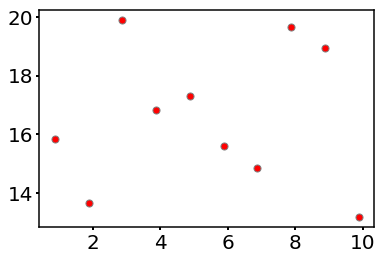

In [31]:
plt.scatter(pos_list_G,t2_B_list, marker='o', s=50, facecolor="red",
         edgecolor='gray', )

No handles with labels found to put in legend.


[1.70964550e+00 1.01361798e+03 3.31283703e-01]
[   3.16432138 1221.3287503     7.9358608 ]
[3.73544187e+00 7.53318237e-01 6.46849899e+02 1.05849732e+04
 1.46290025e+01]
[4.67469328e+00 1.18430155e+00 4.75958255e+02 8.04489899e+03
 2.13746504e+01]
[6.06460253e+00 1.19104862e+00 4.40756393e+02 1.10365643e+04
 2.87887209e+01]
[8.96450395e+00 2.05515333e+00 6.17988423e+02 1.33383281e+04
 3.69412780e+01]
0.003417415093975932
0.0010479578736651007


C:\Users\Zhaodong Chu\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


[1013.6179816054856, 1221.3287502961339, 646.8498985597492, 475.958255422412, 440.7563927529191, 617.9884227436353]
[nan, nan, 10584.97321192703, 8044.898993888755, 11036.564269720133, 13338.328117515837]
[77.97221919961638, 52.175091901206606, 28.58489439431416, 18.379034827544093, 13.14795143209576, 17.33642501273501]


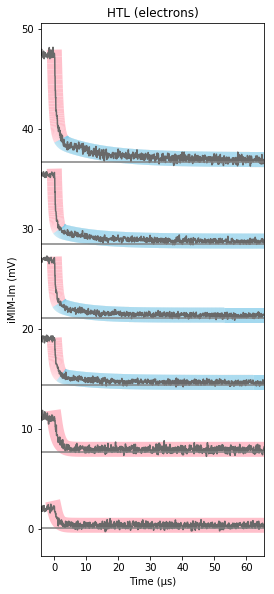

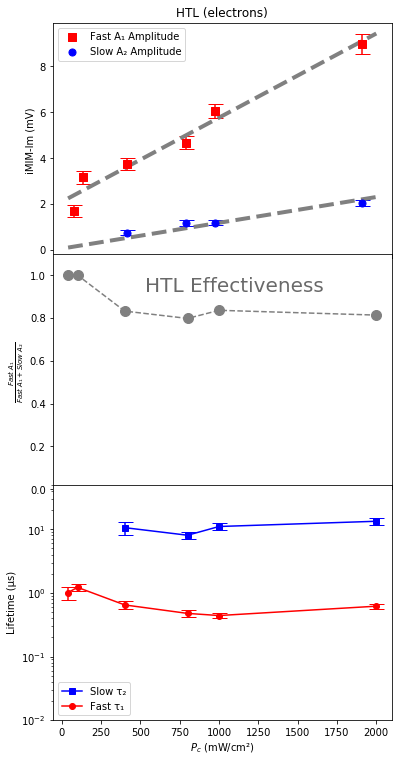

In [4]:
%matplotlib inline
HTL_root = "../Perovskite/HTL_ETL2/HTL_gloveBox/Data/"

HTL_intensity_files = ["2020-06-25_7kHz_result_0.0010_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                       "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-25_7kHz_result_0.0098_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "tmp2020-06-27_7kHz_result_0.0155_446nm_KaiZhu_Provskite_HTLGloveBoxRound2_Im_5usx14ns_average30times_randPos_transposed.csv",
                       "tmp2020-06-27_7kHz_result_0.0216_446nm_KaiZhu_Provskite_HTLGloveBoxRound2_Im_5usx14ns_average30times_randPos_transposed.csv",
                       "2020-06-25_7kHz_result_0.0155_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv"]
HTL_intensity_list = [-pd.read_csv(HTL_root+file,header=None)[0].values for file in HTL_intensity_files]
plt.figure(figsize=(4,7/5*7))
plt.title("HTL (electrons)")
plt.xlabel('Time (µs)')
plt.ylabel('iMIM-Im (mV)')
minor_shift=[0,0,0,0,0,0,]
fast_list = []
slow_list = []
fast_A_list = []
slow_A_list = []
fast_error_list = []
slow_error_list = []
fast_A_error_list = []
slow_A_error_list = []
HTL_buffer = {'x':[],'y':[],'fitx':[],'fity':[],'popt':[],'threshy':[],'yraw':[],'fityraw':[]}

for ind,htl in enumerate(HTL_intensity_list):
    cutoff_raw = 84
#     plt.plot(htl+1.75*ind)
    cutoff = cutoff_raw-minor_shift[ind]
    num_points = 1400
    unit_time = 50
    
    xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
    ydata = htl+7*ind
    plt.plot(xlist[:len(ydata)]/1e3,ydata,color = 'dimgray')
    HTL_buffer['x'].append(xlist[:len(ydata)]/1e3)
    HTL_buffer['y'].append(ydata)
    HTL_buffer['yraw'].append(htl)
    if ind >= 2:
        popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(ydata)],ydata[cutoff:])
        plt.plot([xlist[:len(ydata)][0]/1e3-5,xlist[:len(ydata)][-1]/1e3+5],[popt_new[-1]-0.25,popt_new[-1]-0.25],'-',c='gray')
        HTL_buffer['popt'].append(popt_new)
        fast_ind = np.argmin(popt_new[2:4])
        slow_ind = np.argmax(popt_new[2:4])
        fast_list.append(popt_new[fast_ind+2])
        slow_list.append(popt_new[slow_ind+2])
        fast_A_list.append(popt_new[fast_ind]) 
        slow_A_list.append(popt_new[slow_ind]) 
        fast_error_list.append(perr_new[fast_ind+2])
        slow_error_list.append(perr_new[slow_ind+2])
        fast_A_error_list.append(perr_new[fast_ind]) 
        slow_A_error_list.append(perr_new[slow_ind]) 
        fit_data = decay2(xlist[cutoff:len(ydata)],*popt_new)
        deltay = np.ptp(fit_data)
        prop = popt_new[fast_ind]/(popt_new[fast_ind]+popt_new[slow_ind])
        threshy = np.max(fit_data)-prop*deltay
        fast_fit = []
        slow_fit = []
        plotTwoColors(xlist[cutoff:len(ydata)]/1e3,fit_data,'skyblue','pink',threshy,linewidth=15)
        HTL_buffer['fitx'].append(xlist[cutoff:len(ydata)]/1e3)
        HTL_buffer['fity'].append(fit_data)
        HTL_buffer['fityraw'].append(fit_data-7*ind)
        HTL_buffer['threshy'].append(threshy)
        
    else:
        popt_new,perr_new = curve_fit_new(decay1,xlist[cutoff:len(ydata)],ydata[cutoff:],)
        plt.plot([xlist[:len(ydata)][0]/1e3-5,xlist[:len(ydata)][-1]/1e3+5],[popt_new[-1]-0.25,popt_new[-1]-0.25],'-',c='gray')
        HTL_buffer['popt'].append(popt_new)
        fast_list.append(popt_new[1])
        fast_A_list.append(popt_new[0]) 
        slow_list.append(np.nan)
        slow_A_list.append(0)
        fast_error_list.append(perr_new[1])
        fast_A_error_list.append(perr_new[0]) 
        slow_error_list.append(np.nan)
        slow_A_error_list.append(0)
        fit_data = decay1(xlist[cutoff:len(ydata)],*popt_new)
        plt.plot(xlist[cutoff:len(ydata)]/1e3,fit_data,color='pink',linewidth=15,zorder=-8)
        HTL_buffer['fitx'].append(xlist[cutoff:len(ydata)]/1e3)
        HTL_buffer['fity'].append(fit_data)
        HTL_buffer['fityraw'].append(fit_data-7*ind)
        HTL_buffer['threshy'].append(None)
plt.legend(edgecolor='None')
plt.xlim(xlist[:len(ydata)][0]/1e3,xlist[:len(ydata)][-1]/1e3)
        
# plt.figure()        
fig,axs = plt.subplots(3,1,figsize=(5,10))
ax = axs[0]
intensity_list = [40,100,400,800,1000,2000]
ax.scatter(intensity_list,fast_A_list,label='Fast A₁ Amplitude',color = 'red',s=50,zorder=10,marker='s')
ax.errorbar(intensity_list,fast_A_list,fmt='-_',yerr=3*np.asarray(fast_A_error_list),capsize=7.5,color='red',ls='none')
m,b = np.polyfit(intensity_list, fast_A_list, 1)
print(m)
ax.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)

ax.scatter(intensity_list[2:],slow_A_list[2:],label='Slow A₂ Amplitude',color = 'blue',s=50,zorder=10)
ax.errorbar(intensity_list[2:],slow_A_list[2:],fmt='-_',yerr=3*np.asarray(slow_A_error_list[2:]),capsize=7.5,color='blue',ls='none')
m,b = np.polyfit(intensity_list, slow_A_list, 1)
print(m)
ax.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)


ax.legend()
ax.set_title('HTL (electrons)')
# ax.set_xlabel("$P_c$ (mW/cm²)")
ax.set_ylabel('iMIM-Im (mV)')
ax.set_xticks([])

# plt.figure()
ax = axs[1]
ax.plot(intensity_list,[item2/(item1+item2) for item1,item2 in zip(slow_A_list,fast_A_list)],'.--',markersize=20,color='gray')
ax.set_ylim(0,1.1)
# ax.set_title('HTL Effectiveness')
ax.text(1100,0.95, 'HTL Effectiveness', ha="center", va="center", rotation=0,fontsize=20,color='dimgray')

# ax.set_xlabel("$P_c$ (mW/cm²)")
ax.set_ylabel('$\\frac{Fast\ A₁}{Fast\ A₁+Slow\ A₂}$')
ax.set_xticks([])

# plt.figure()
ax = axs[2]
ETL_t_list = slow_list
HTL_t_list = fast_list
ETL_mean = np.nanmean(ETL_t_list)/1e3
HTL_mean = np.nanmean(HTL_t_list)/1e3
ax.plot(intensity_list,np.asarray(ETL_t_list)/1e3,color='blue',marker='s',label='Slow τ₂')#label='$\overline{τ}_{hole}$='+'{:.2f}'.format(ETL_mean)+'µs')
ax.errorbar(intensity_list,np.asarray(ETL_t_list)/1e3,fmt='-_',yerr=3*np.asarray(slow_error_list)/1e3,capsize=7.5,color='blue',ls='none')
ax.plot(intensity_list,np.asarray(HTL_t_list)/1e3,color='red',marker='o',label='Fast τ₁')#label='$\overline{τ}_{electron}$='+'{:.2f}'.format(HTL_mean)+'µs')
ax.errorbar(intensity_list,np.asarray(HTL_t_list)/1e3,fmt='-_',yerr=3*np.asarray(fast_error_list)/1e3,capsize=7.5,color='red',ls='none')
ax.set_yscale('log')
ax.set_ylim(1e-2,5e1)
ax.legend(loc='lower left')
ax.set_ylabel('Lifetime (µs)')
ax.set_xlabel("$P_c$ (mW/cm²)")
# ax.set_title('HTL (electrons)')
fig.tight_layout(pad=-1.4)
plt.savefig('./imgs/htl_analysis.png',bbox_inches='tight',dpi=300)
print(fast_list)
print(slow_list)
print(fast_error_list)

In [97]:
print(*list(HTL_buffer['fityraw'][5]),sep='\n')

12.960935243733424
12.25651413917771
11.60627258814143
11.006001821693111
10.451820173313429
9.940147656148248
9.467682516146738
9.031379607516563
8.628430448863512
8.25624482939083
7.912433844685893
7.594794250984954
7.301294035442382
7.030059107895127
6.779361026958476
6.547605680063711
6.333322843296173
6.135156552654671
5.951856223667569
5.7822684612024915
5.62532950582694
5.4800582672463705
5.345549899191383
5.220969873671997
5.105548515787646
4.998575963297867
4.89939751794094
4.807409358053249
4.722054584408724
4.6428195733801445
4.569230613536767
4.500850803649435
4.437277191786173
4.3781381367604695
4.323090874650788
4.2718192744528025
4.224031768164913
4.179459441749771
4.137854274468353
4.098987515054986
4.062648184097732
4.028641692815512
3.996788569185263
3.9669232830759285
3.938893162694278
3.912557395245692
3.8877861052646807
3.864459504578498
3.8424671083364785
3.8217070119703678
3.8020852243500656
3.78351505276715
3.7659165357181195
3.7492159197722756
3.733345177097916

In [14]:
HTL_intensity_list[0]

array([1.86666667, 1.86666667, 2.16666667, ..., 0.16666667, 0.16666667,
       0.4       ])

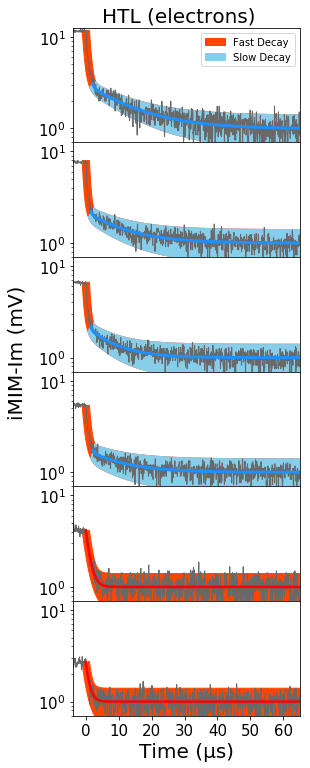

In [9]:
small_or_big = 'big'

fig,axs = plt.subplots(len(HTL_buffer['x']),1,figsize=(3,10))
fig.tight_layout(pad=-2.1)
# fig.legend()
fig.suptitle('HTL (electrons)',fontsize=20)
# fig.ylabel('')
fig.subplots_adjust(top=0.95)
# fig.xlabel("$P_c$ (mW/cm²)")
# fig.ylabel('iMIM-Im (mV)')
# for ind in range(len(HTL_buffer['x'])-1,0-1,-1):
plt.xlabel('Time (µs)',fontsize=20)
fig=axs[0].figure

range_list = [1,1,1,1,1,1,]

for ind in range(len(HTL_buffer['x'])):
    ax = axs[ind]
    ind2 = len(HTL_buffer['x'])-ind-1
    x,y,fitx,fity,y0,threshy = HTL_buffer['x'][ind2],HTL_buffer['y'][ind2],HTL_buffer['fitx'][ind2],HTL_buffer['fity'][ind2],HTL_buffer['popt'][ind2][-1],HTL_buffer['threshy'][ind2]
    miny = min(fity)-1#0.35#0.25
    y = y-miny
    fity=fity-miny
    
    if small_or_big == 'big':
        xlim = (-4,65)
        ax.set_xlim(*xlim)
        if ind == 0:
            fig.text(-0.25,0.5, 'iMIM-Im (mV)', ha="center", va="center", rotation=90,fontsize=20)
        ax.set_yscale('log')
        width_fast=1.1
        width_slow=1.1
        ratio_figsize=2.75#0.75
        linewidth = 1
        ylim = (range_list[ind2]*7e-1,12.5)
        for item in ax.xaxis.get_major_ticks()+ax.yaxis.get_major_ticks():
            item.label.set_fontsize(15)
    elif small_or_big == 'small':
        fig.tight_layout()
        xlim = (-1,10)
        ylim = (range_list[ind2]*7e-2,max(y)+0.05*(max(y)-min(y)))
        ax.set_xlim(*xlim)
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        for item in ax.xaxis.get_major_ticks()+ax.yaxis.get_major_ticks():
            item.label.set_fontsize(18)
        fig.suptitle('')
        plt.xlabel('')
        width_fast=0.25
        width_slow=0.25
        ratio_figsize=0.75/(60/(max(xlim)-min(xlim)))/(max(ylim)-min(ylim))*7
        linewidth = 3
        fig.tight_layout(pad=5)
        fig.set_size_inches((6,20))
        ylim = (range_list[ind2]*7e-1,12.5)

    else:
        raise ValueError('small_or_big has to be either "small" or "big"')    
#     y = data_avefilter(y,num=2)
#     y = data_avefilter(y,num=2)
#     y = data_lfilter(y)
#     ax.scatter(x,y,marker='o',s=7,c='black')

    ax.plot(x,y,c='dimgray',linewidth=linewidth,)#markersize=3)
#     ax.plot(fitx,fity,c='red',linewidth=2.5)
    
#     ax.set_yscale('log')
    if ind2>=2:
        threshy = threshy-miny
        xslow=[]
        yslow=[]
        for j,ypos in enumerate(fity):
            if ypos<threshy:
                xslow.append(fitx[j])
                yslow.append(fity[j])
        ax.plot(xslow,yslow,c='dodgerblue',linewidth=3)
        plot_equidistant(fitx,fity,width=width_fast,ratio_figsize=ratio_figsize,ax=ax,color='orangered',zorder=-5,label='Fast Decay')
        plot_equidistant(xslow,yslow,width=width_slow,ratio_figsize=ratio_figsize,ax=ax,color='skyblue',zorder=-5,label='Slow Decay')
        if ind==0:
            ax.legend()
#         plotTwoColors(fitx,fity,'skyblue','pink',threshy,linewidth=30,ax=ax)
    else:
#         ax.plot(xfast,yfast,color='red',linewidth=3)
        ax.plot(fitx,fity,c='red',linewidth=2.5)
        plot_equidistant(fitx,fity,width=width_slow,ratio_figsize=ratio_figsize,ax=ax,color='orangered',zorder=-5)
        None
#     rg = max(y)-min(y)
    ax.set_ylim(*ylim)
    
    if ind != len(HTL_buffer['x'])-1 and small_or_big == 'big':
        ax.get_xaxis().set_visible(False)
#     ax.spines["right"].set_visible(False)
plt.savefig('./imgs/htl.png',bbox_inches='tight',dpi=300)

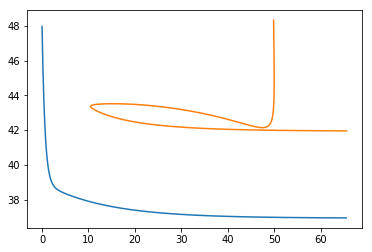

In [773]:
x,y = HTL_buffer['fitx'][-1],HTL_buffer['fity'][-1]
x = x.astype(np.float64)
y = y.astype(np.float64)
grad = np.gradient(y,x)
theta = abs(np.arctan(grad))
# for ind in range(len(theta)):
#     if theta[ind]<0 and (not np.isclose(theta[ind],0.)):
#         theta[ind]+=np.pi
# theta = np.pi+theta
dx = 50
dy = 5
newx = x+dx*np.sin(theta)
newy = y+dy*np.cos(theta)
plt.plot(x,y)
# plt.plot(x,np.gradient(y,x))
plt.plot(newx,newy)

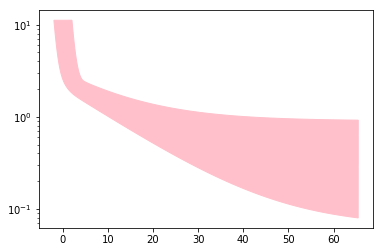

In [803]:
x,y = HTL_buffer['fitx'][-1],HTL_buffer['fity'][-1]




ratio_figsize = 0.8
width = 2
y = y.copy()
y-=min(y)-0.5
plot_equidistant(x,y,width,ratio_figsize,ax=None,color='pink')

In [776]:
x,y = HTL_buffer['fitx'][-1],HTL_buffer['fity'][-1]

y

array([1087.4476263 , 1071.47585565, 1056.73253116, ...,  837.93809337,
        837.93679917,  837.9355098 ])

In [682]:
pol

array([-4. ,  5.5, -2.5,  0.2])

No handles with labels found to put in legend.


[1.46881667e+00 8.68290390e+03 5.54999262e-01]
[1.84170660e+00 8.28172718e+03 5.75045658e+00]
[1.31955252e+00 2.59954205e+00 7.68000000e+02 8.42529119e+03
 1.05189544e+01]
[1.96632637e+00 2.99626359e+00 7.51926150e+02 8.03198554e+03
 1.54907613e+01]
[2.69509331e+00 3.89343058e+00 6.92326928e+02 7.94270420e+03
 2.10443580e+01]
[4.83730558e+00 5.13741182e+00 5.87881100e+02 7.22271092e+03
 2.62838259e+01]
0.0024867278203169383
0.00182366894915112


C:\Users\Zhaodong Chu\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


[8682.903903139735, 8281.72717913675, 8425.291193256046, 8031.985535796504, 7942.704202833372, 7222.710921974838]


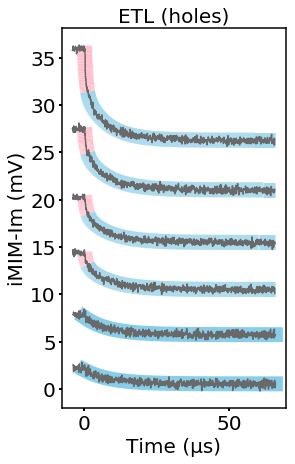

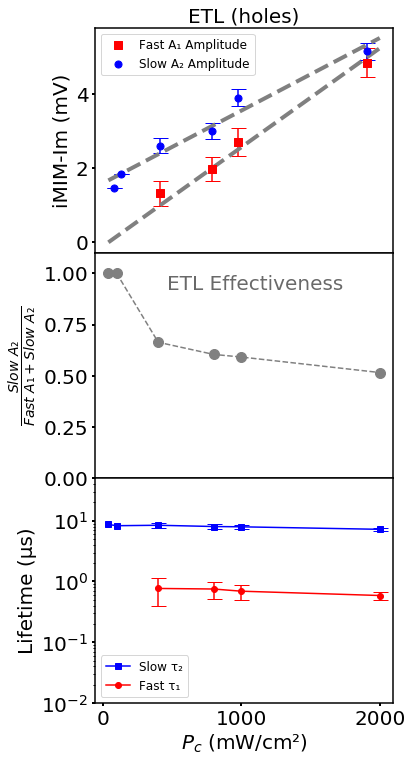

In [130]:
%matplotlib inline
ETL_root = "../Perovskite/HTL_ETL2/ETL_TiO2_firstBatch/Data/"

ETL_intensity_files = [#"2020-06-26_7kHz_result_0.0004_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0010_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      #"2020-06-26_7kHz_result_0.0030_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0050_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0084_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0098_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      ##"2020-06-26_7kHz_result_0.0155_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0216_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      #"tmp2020-06-27_7kHz_result_0.0261_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchVacuumChamber_Im_5usx14ns_average30times_randPos_transposed.csv",
                      #"tmp2020-06-27_7kHz_result_0.0270_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchVacuumChamber_Im_5usx14ns_average30times_randPos_transposed.csv"
                      ]
ETL_intensity_list = [-pd.read_csv(ETL_root+file,header=None)[0].values for file in ETL_intensity_files]
plt.figure(figsize=(4,7))
plt.title("ETL (holes)")
plt.xlabel('Time (µs)')
plt.ylabel('iMIM-Im (mV)')

minor_shift=[5,5,1,2,0,0,0,]
fast_list = []
slow_list = []
fast_A_list = []
slow_A_list = []
fast_error_list = []
slow_error_list = []
fast_A_error_list = []
slow_A_error_list = []
ETL_buffer = {'x':[],'y':[],'fitx':[],'fity':[],'popt':[],'threshy':[],'yraw':[],'fityraw':[]}
for ind,etl in enumerate(ETL_intensity_list):
    cutoff_raw = 82
    cutoff = cutoff_raw-minor_shift[ind]
    num_points = 1400
    unit_time = 50
    xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
    ydata = etl+5*ind
    plt.plot(xlist[:len(ydata)]/1e3,ydata,color='dimgray')
    ETL_buffer['x'].append(xlist[:len(ydata)]/1e3)
    ETL_buffer['y'].append(ydata)
    ETL_buffer['yraw'].append(etl)
    if ind >=2:
        popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(ydata)],ydata[cutoff:],bounds=[[0,0,0,5e3/unit_time,0],[np.inf,np.inf,768/unit_time,np.inf,np.inf]])

        ETL_buffer['popt'].append(popt_new)
        fast_ind = np.argmin(popt_new[2:4])
        slow_ind = np.argmax(popt_new[2:4])
        fast_list.append(popt_new[fast_ind+2])
        slow_list.append(popt_new[slow_ind+2])
        fast_A_list.append(popt_new[fast_ind]) 
        slow_A_list.append(popt_new[slow_ind]) 
        fast_error_list.append(perr_new[fast_ind+2])
        slow_error_list.append(perr_new[slow_ind+2])
        fast_A_error_list.append(perr_new[fast_ind]) 
        slow_A_error_list.append(perr_new[slow_ind]) 
        fit_data = decay2(xlist[cutoff:len(ydata)],*popt_new)
        deltay = np.ptp(fit_data)
        prop = popt_new[fast_ind]/(popt_new[fast_ind]+popt_new[slow_ind])
        threshy = np.max(fit_data)-prop*deltay
#         print(prop)
        fast_fit = []
        slow_fit = []
        plotTwoColors(xlist[cutoff:len(ydata)]/1e3,fit_data,'skyblue','pink',threshy,linewidth=15)
        ETL_buffer['fitx'].append(xlist[cutoff:len(ydata)]/1e3)
        ETL_buffer['fity'].append(fit_data)
        ETL_buffer['fityraw'].append(fit_data-5*ind)
        ETL_buffer['threshy'].append(threshy)
    else:
        popt_new,perr_new = curve_fit_new(decay1,xlist[cutoff:len(ydata)],ydata[cutoff:])
        ETL_buffer['popt'].append(popt_new)
        slow_list.append(popt_new[1])
        slow_A_list.append(popt_new[0]) 
        fast_list.append(np.nan)
        fast_A_list.append(0)
        fast_error_list.append(perr_new[1])
        fast_A_error_list.append(perr_new[0]) 
        slow_error_list.append(np.nan)
        slow_A_error_list.append(0)
        fit_data = decay1(xlist[cutoff:len(ydata)],*popt_new)
        plt.plot(xlist[cutoff:len(ydata)]/1e3,fit_data,color='skyblue',linewidth=15,zorder=-8)
        ETL_buffer['fitx'].append(xlist[cutoff:len(ydata)]/1e3)
        ETL_buffer['fity'].append(fit_data)
        ETL_buffer['fityraw'].append(fit_data-5*ind)
        ETL_buffer['threshy'].append(None)
plt.legend(edgecolor='None')
    
#     plt.plot(xlist[cutoff:len(ydata)]/1e3,decay2(xlist[cutoff:len(ydata)],*popt_new),color='red',linewidth=2)
#     plt.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],popt_new[slow_ind],popt_new[slow_ind+2],popt_new[-1])-popt_new[-1]/offsetdiv,color='red',linewidth=2)
#     plt.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],popt_new[fast_ind],popt_new[fast_ind+2],popt_new[-1])-popt_new[-1]/offsetdiv,color='red',linewidth=2)
plt.figure() 

fig,axs = plt.subplots(3,1,figsize=(5,10))
ax = axs[0]
intensity_list = [40,100,400,800,1000,2000]
ax.scatter(intensity_list[2:],fast_A_list[2:],label='Fast A₁ Amplitude',color = 'red',s=50,zorder=10,marker='s')
ax.errorbar(intensity_list[2:],fast_A_list[2:],fmt='-_',yerr=3*np.asarray(fast_A_error_list[2:]),capsize=7.5,color='red',ls='none')


m,b = np.polyfit(intensity_list, fast_A_list, 1)
print(m)
ax.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)

ax.scatter(intensity_list,slow_A_list,label='Slow A₂ Amplitude',color = 'blue',s=50,zorder=10)
ax.errorbar(intensity_list,slow_A_list,fmt='-_',yerr=3*np.asarray(slow_A_error_list),capsize=7.5,color='blue',ls='none')


m,b = np.polyfit(intensity_list, slow_A_list, 1)
print(m)
ax.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)


ax.legend()
ax.set_title('ETL (holes)')
# ax.set_xlabel("$P_c$ (mW/cm²)")
ax.set_ylabel('iMIM-Im (mV)')
ax.set_xticks([])


# plt.figure()
ax = axs[1]
ax.plot(intensity_list,[item1/(item1+item2) for item1,item2 in zip(slow_A_list,fast_A_list)],'.--',markersize=20,color='gray')
ax.set_ylim(0,1.1)
# ax.set_title('ETL Effectiveness')
ax.text(1100,0.95, 'ETL Effectiveness', ha="center", va="center", rotation=0,fontsize=20,color='dimgray')
# ax.set_xlabel("$P_c$ (mW/cm²)")
ax.set_ylabel('$\\frac{Slow\ A₂}{Fast\ A₁+Slow\ A₂}$')
ax.set_xticks([])

# plt.figure()
ax = axs[2]
ETL_t_list = slow_list
HTL_t_list = fast_list
ETL_mean = np.nanmean(ETL_t_list)/1e3
HTL_mean = np.nanmean(HTL_t_list)/1e3
ax.plot(intensity_list,np.asarray(ETL_t_list)/1e3,color='blue',marker='s',label='Slow τ₂')#label='$\overline{τ}_{hole}$='+'{:.2f}'.format(ETL_mean)+'µs')
ax.errorbar(intensity_list,np.asarray(ETL_t_list)/1e3,fmt='-_',yerr=3*np.asarray(slow_error_list)/1e3,capsize=7.5,color='blue',ls='none')
ax.plot(intensity_list,np.asarray(HTL_t_list)/1e3,color='red',marker='o',label='Fast τ₁')#label='$\overline{τ}_{electron}$='+'{:.2f}'.format(HTL_mean)+'µs')
ax.errorbar(intensity_list,np.asarray(HTL_t_list)/1e3,fmt='-_',yerr=3*np.asarray(fast_error_list)/1e3,capsize=7.5,color='red',ls='none')
ax.set_yscale('log')
ax.set_ylim(1e-2,5e1)
ax.legend(loc='lower left')
ax.set_ylabel('Lifetime (µs)')
ax.set_xlabel("$P_c$ (mW/cm²)")
# ax.set_title('ETL (holes)')
fig.tight_layout(pad=-1.4)

plt.savefig('./imgs/etl_analysis.png',bbox_inches='tight',dpi=300)
print(slow_list)

In [134]:
slow_list

[8682.903903139735,
 8281.72717913675,
 8425.291193256046,
 8031.985535796504,
 7942.704202833372,
 7222.710921974838]

In [119]:
print(*list(ETL_buffer['fityraw'][5]),sep='\n')

11.25854330717705
10.828693315381983
10.431245824801834
10.063577154027442
9.723277416974526
9.408133092003098
9.11611101225352
8.845343661320477
8.594115667834778
8.360851401200136
8.144103578702655
7.9425428015311255
7.7549479439694835
7.580197326198444
7.417260606814857
7.26519133638692
7.123120118147803
6.99024832632486
6.865842336637872
6.749228227206636
6.639786911513369
6.536949668192385
6.440194035291903
6.3490400392909265
6.263046731576932
6.181809007315817
6.104954683689243
6.032141816351995
5.963056234686203
5.89740927801288
5.834935716375821
5.775391840848826
5.71855370954426
5.664215536627907
5.612188212680145
5.562297945694219
5.5143850128755005
5.468302614207698
5.423915819488393
5.381100601213063
5.339742946307904
5.299738040282609
5.260989517898366
5.223408774927837
5.186914336025971
5.151431274136812
5.116890677234203
5.083229158537215
5.0503884066555145
5.018314772409088
4.986958889332101
4.95627532511449
4.926222261458804
4.896761200035559
4.867856692409088
4.839476

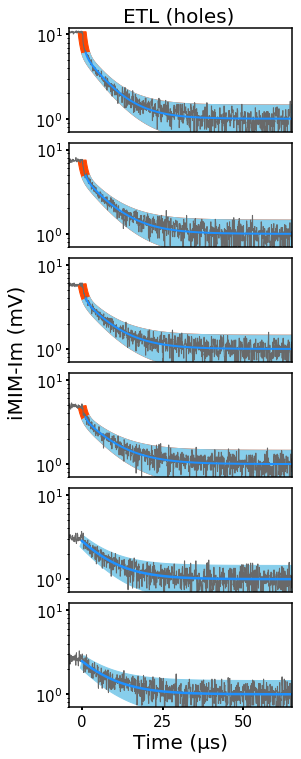

In [39]:
small_or_big = 'big'

fig,axs = plt.subplots(len(ETL_buffer['x']),1,figsize=(3,10))
fig.tight_layout(pad=-2.1)
# fig.legend()
fig.suptitle('ETL (holes)',fontsize=20)
# fig.ylabel('')
fig.subplots_adjust(top=0.95)
# fig.xlabel("$P_c$ (mW/cm²)")
# fig.ylabel('iMIM-Im (mV)')
# for ind in range(len(ETL_buffer['x'])-1,0-1,-1):
plt.xlabel('Time (µs)',fontsize=20)
fig=axs[0].figure

range_list = [1,1,1,1,1,1,]


for ind in range(len(ETL_buffer['x'])):
    ax = axs[ind]
    

    ind2 = len(ETL_buffer['x'])-ind-1
    x,y,fitx,fity,y0,threshy = ETL_buffer['x'][ind2],ETL_buffer['y'][ind2],ETL_buffer['fitx'][ind2],ETL_buffer['fity'][ind2],ETL_buffer['popt'][ind2][-1],ETL_buffer['threshy'][ind2]
    miny = min(fity)-1
    y = y-miny
    fity=fity-miny
    
    if small_or_big == 'big':
        xlim = (-4,65)
        ax.set_xlim(*xlim)
        if ind == 0:
            fig.text(-0.25,0.5, 'iMIM-Im (mV)', ha="center", va="center", rotation=90,fontsize=20)
        ax.set_yscale('log')
        width_fast=1.25
        width_slow=1.25
        ratio_figsize=2.75
        linewidth = 1
        ylim = (range_list[ind2]*7e-1,12)
        for item in ax.xaxis.get_major_ticks()+ax.yaxis.get_major_ticks():
            item.label.set_fontsize(15)
    elif small_or_big == 'small':
        fig.tight_layout()
        xlim = (-1,7.5)
        ylim = (range_list[ind2]*7e-1,max(y)+0.05*(max(y)-min(y)))
        ax.set_xlim(*xlim)
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        for item in ax.xaxis.get_major_ticks()+ax.yaxis.get_major_ticks():
            item.label.set_fontsize(25)
        fig.suptitle('')
        plt.xlabel('')
        width_fast=0.6
        width_slow=0.6
        ratio_figsize=0.75/(60/(max(xlim)-min(xlim)))/(max(ylim)-min(ylim))*7*5
#         print(ratio_figsize)
        linewidth = 3
        fig.tight_layout(h_pad=8,pad=6)
        fig.set_size_inches((5,20))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.locator_params(nbins=4, axis='y')
    else:
        raise ValueError('small_or_big has to be either "small" or "big"')
#     y = data_avefilter(y,num=2)
#     y = data_avefilter(y,num=2)
#     y = data_lfilter(y)
#     ax.scatter(x,y,marker='o',s=7,c='black')

    ax.plot(x,y,c='dimgray',linewidth=linewidth,)#markersize=3)
#     ax.plot(fitx,fity,c='red',linewidth=2.5)
    
    
    if ind2>=2:
        threshy = threshy-miny
        xslow=[]
        yslow=[]
        for j,ypos in enumerate(fity):
            if ypos<threshy:
                xslow.append(fitx[j])
                yslow.append(fity[j])
        ax.plot(xslow,yslow,c='dodgerblue',linewidth=2)
        plot_equidistant(fitx,fity,width=width_fast,ratio_figsize=ratio_figsize,ax=ax,color='orangered',zorder=-5,label='Fast Decay')
        plot_equidistant(xslow,yslow,width=width_slow,ratio_figsize=ratio_figsize,ax=ax,color='skyblue',zorder=-5,label='Slow Decay')
        if ind==0 and small_or_big == 'big':
#             ax.legend()
            None
#         plotTwoColors(fitx,fity,'skyblue','pink',threshy,linewidth=30,ax=ax)
    else:
#         ax.plot(xfast,yfast,color='red',linewidth=3)
        ax.plot(fitx,fity,c='dodgerblue',linewidth=2.5)
        plot_equidistant(fitx,fity,width=width_slow,ratio_figsize=ratio_figsize,ax=ax,color='skyblue',zorder=-5)

        None
#     rg = max(y)-min(y)
    ax.set_ylim(*ylim)
    
    if ind != len(ETL_buffer['x'])-1 and small_or_big == 'big':
        ax.get_xaxis().set_visible(False)
#     ax.spines["right"].set_visible(False)
plt.savefig('./imgs/etl_'+small_or_big+'.png',bbox_inches='tight',dpi=300)

In [475]:
ETL_buffer

{'fitx': [array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.550e+01, 6.555e+01,
         6.560e+01]),
  array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.550e+01, 6.555e+01,
         6.560e+01]),
  array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.550e+01, 6.555e+01,
         6.560e+01]),
  array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.550e+01, 6.555e+01,
         6.560e+01]),
  array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.550e+01, 6.555e+01,
         6.560e+01]),
  array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.550e+01, 6.555e+01,
         6.560e+01])],
 'fity': [array([1.94411953, 1.93640014, 1.92872356, ..., 0.55299458, 0.55298928,
         0.55298402]),
  array([7.50378925, 7.49346786, 7.48320716, ..., 5.74897306, 5.7489685 ,
         5.74896397]),
  array([14.07712834, 14.02537479, 13.97488941, ..., 10.5077508 ,
         10.50773839, 10.50772603]),
  array([20.03882987, 19.92987041, 19.82608514, ..., 15.48988434,
         15.48987854, 15.48987277]),
  array([27.63184277, 27.419886  , 27

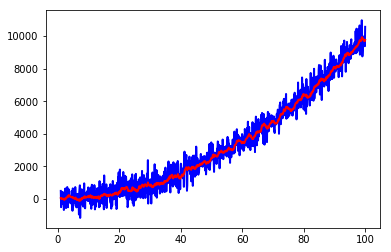

In [34]:
mu, sigma = 0, 500

x = np.arange(1, 100, 0.1)  # x axis
z = np.random.normal(mu, sigma, len(x))  # noise
y = x ** 2 + z # data
plt.plot(x, y, linewidth=2, linestyle="-", c="b")  # it include some noise

n = 15  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,y)
plt.plot(x, yy, linewidth=2, linestyle="-", c="r")  # smooth by filter

In [463]:
[item1/(item2+item1) for item1,item2 in zip(fast_A_list,slow_A_list)]
# fast_list

[0.6580231352044766,
 0.2986255789091342,
 0.37236063280396664,
 0.36082558232878265,
 0.40905935082647227,
 0.484957019114694]

[8.20685928e-01 1.22919948e+03 1.90874198e-01]
[7.76740914e-01 9.71629727e+02 2.44393520e-01]
[7.70429092e-01 8.34830945e+02 2.07350263e-01]
[7.49829185e-01 1.12449916e+03 2.95207196e-01]
[7.42082033e-01 9.00826721e+02 2.59392494e-01]
[-4.25 -4.2  -4.15 ... 65.35 65.4  65.45]
[8.20685928e-01 1.22919948e+03 1.90874198e-01]
[7.76740914e-01 9.71629727e+02 2.44393520e-01]
[7.70429092e-01 8.34830945e+02 2.07350263e-01]
[7.49829185e-01 1.12449916e+03 2.95207196e-01]
[7.42082033e-01 9.00826721e+02 2.59392494e-01]
[-4.25 -4.2  -4.15 ... 65.35 65.4  65.45]
[1229.199479116272, 971.6297274704463, 834.8309452178518, 1124.4991620086132, 900.8267206067198]
1012.1972068839805


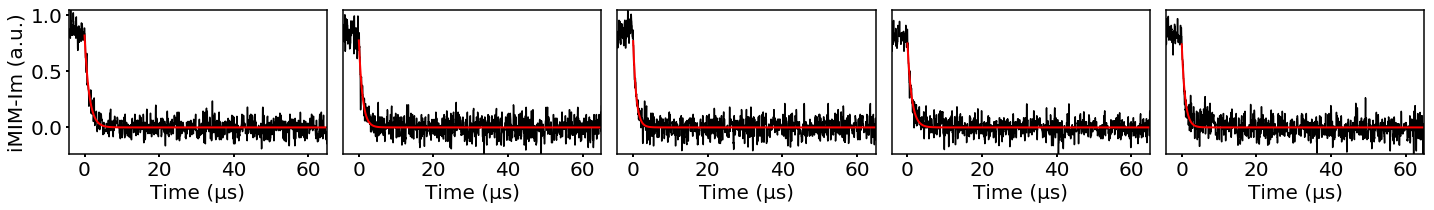

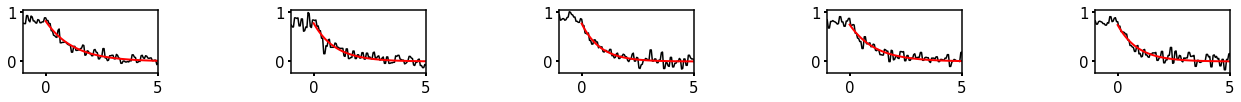

In [166]:
%matplotlib inline
HTL_root1 = "../Perovskite/HTL_ETL2/HTL_gloveBox/Data/"
HTL_root2 = "../Perovskite/HTL_ETL2/HTL_measuredDiffusion/Data/"

HTL_pos_files1 = ["2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos2_transposed.csv",
                "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos3_transposed.csv",
                "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos4_transposed.csv",
                ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos5_transposed.csv"
                ]
HTL_pos_files2 = [##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos_transposed.csv",
                  ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos2_transposed.csv",
                  ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos3_transposed.csv",
                  "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos4_transposed.csv",
                  "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos5_transposed.csv",
                 ]

HTL_pos_list = [-pd.read_csv(HTL_root1+file,header=None)[0].values for file in HTL_pos_files1]+\
                [-pd.read_csv(HTL_root2+file,header=None)[0].values for file in HTL_pos_files2]
# plt.figure(figsize=(5,5))
# plt.title("random positions for HTL")
# for ind,htl in enumerate(HTL_pos_list):
#     plt.plot(htl+1.75*ind)
buffer = []
HTL_t_list,_,_,HTL_error_list,_,_ = plotPos(HTL_pos_list,decay=1,cutoff_raw=85,log=False,ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8,buffer=buffer)
plotPos(HTL_pos_list,decay=1,cutoff_raw=85,log=False,xlim=(-1,5),ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8,smallWindows=1,pad=10,height=4)
print(HTL_t_list)
print(np.mean(HTL_t_list))



In [172]:
print(*buffer[4],sep='\n')

0.7420820330200693
0.7020153173916066
0.6641118958867314
0.6282549672804931
0.5943340367146996
0.5622445752026728
0.5318876975181244
0.503169857475553
0.4760025596631536
0.45030208673992883
0.425989241456658
0.4029891026057462
0.38123079414790345
0.3606472668042035
0.34117509144049213
0.32275426360744414
0.3053280186339538
0.28884265670405834
0.2732473773783585
0.25849412305001146
0.2445374308528922
0.23133429256557464
0.21884402207941966
0.20702813002236464
0.19585020515206375
0.18527580215288536
0.1752723354910073
0.16580897900051977
0.15685657089110533
0.1483875238845735
0.14037574020332905
0.1327965311488098
0.125626541022069
0.11884367515206012
0.11242703180984054
0.10635683779888383
0.10061438752301904
0.09518198534423222
0.09004289105270302
0.08518126828103878
0.0805821357037434
0.07623132087153905
0.07211541653827858
0.06822173934586878
0.06453829073988954
0.06105371999546849
0.0577572892394741
0.05463884036124034
0.05168876370985809
0.04889796848157141
0.0462578547060265
0.043

array([0.74208203, 0.70201532, 0.6641119 , ..., 0.        , 0.        ,
       0.        ])

[2.98855222e-01 6.52327727e-01 8.93865110e+02 9.38863030e+03
 2.19070763e-01]
[4.99991920e-01 3.95799829e-01 2.13228024e+03 1.10388998e+04
 2.52491676e-01]
[4.08934635e-01 5.03488755e-01 1.50470305e+03 9.59512791e+03
 2.15474559e-01]
[4.06633227e-01 4.35478441e-01 1.78737885e+03 1.03007665e+04
 2.45635892e-01]
[3.51125654e-01 5.65435609e-01 1.08326754e+03 8.46107904e+03
 2.39850316e-01]
[-3.55 -3.5  -3.45 ... 66.05 66.1  66.15]
[9388.630301889087, 11038.899840627337, 9595.127909094956, 10300.766514673389, 8461.079040687006]
9756.900721394355


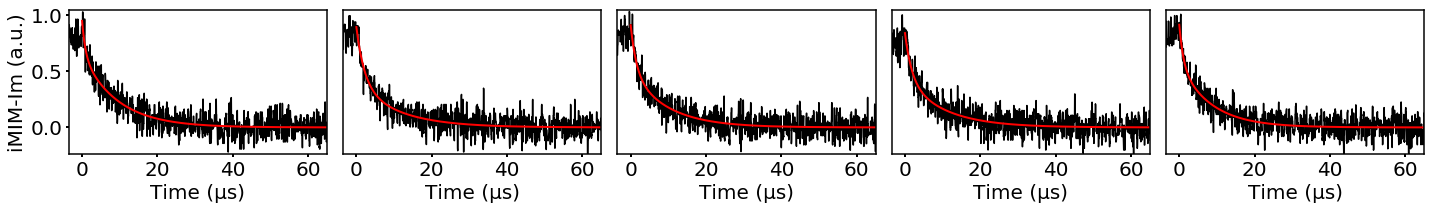

In [173]:
%matplotlib inline
ETL_root1 = "../Perovskite/HTL_ETL2/ETL_TiO2_firstBatch/Data/"
ETL_root2 = "../Perovskite/HTL_ETL2/ETL_TiO2_firstBatch_GloveBox/Data/"


ETL_pos_files1 = ["2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos2_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos3_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos4_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos5_transposed.csv"
                 ]

ETL_pos_files2 = [#"2020-06-27_7kHz_result_0.0018_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                  #"2020-06-27_7kHz_result_0.0018_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchGloveBox_Im_5usx14ns_average30times_randPos2_transposed.csv",
                 ]




ETL_pos_list = [-pd.read_csv(ETL_root1+file,header=None)[0].values for file in ETL_pos_files1]+\
                [-pd.read_csv(ETL_root2+file,header=None)[0].values for file in ETL_pos_files2]
# plt.figure(figsize=(5,5))
# plt.title("random positions of ETL (holes)")


# ETL_t_list = plotPos(ETL_pos_list,decay=1,cutoff_raw=75,log=False,ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8)
buffer = []
_,_,ETL_t_list,_,_,ETL_error_list = plotPos(ETL_pos_list,buffer=buffer,decay=2,cutoff_raw=71,log=False,ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8)
# plt.xlim(-5,10)
# np.mean(ETL_t_list)
print(ETL_t_list)
print(np.mean(ETL_t_list))

In [187]:
print(*buffer[4],sep='\n')

0.9165612627548161
0.8973912772921353
0.8789553560573105
0.861221156929457
0.8441577921286754
0.8277357626408957
0.8119268956005037
0.7967042844973333
0.7820422320806235
0.7679161958382885
0.7543027359353346
0.7411794655004993
0.7285250031551904
0.7163189276835815
0.7045417347472815
0.6931747955523542
0.6822003173806208
0.6716013059011575
0.6613615291816817
0.651465483323157
0.6418983596443925
0.6326460133467238
0.6236949335920134
0.6150322149302189
0.6066455300156535
0.598523103553812
0.5906536874232532
0.5830265369195364
0.5756313880705993
0.5684584359752484
0.5614983141186112
0.554742074620485
0.5481811693745002
0.5418074320379166
0.5356130608336844
0.5295906021281314
0.5237329347492885
0.5180332550124488
0.5124850624210574
0.5070821460124704
0.5018185713194957
0.4966886679199404
0.4916870175476402
0.4868084427396471
0.48204799599538806
0.4774009494247048
0.47286278486272104
0.4684291844304811
0.46409602152125284
0.45985935219329566
0.45571540695075796
0.45166058289519884
0.44769143

In [178]:
ETL_error_list

[500.8528104955633,
 1462.9819195602254,
 831.4537568210894,
 1166.4878745918127,
 585.6557016937174]

Text(0.5,0,'Sampling points')

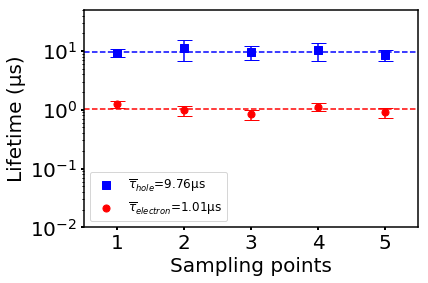

In [188]:
ETL_mean = np.mean(ETL_t_list)/1e3
HTL_mean = np.mean(HTL_t_list)/1e3
plt.scatter(np.arange(1,6),np.asarray(ETL_t_list)/1e3,color='blue',marker='s',label='$\overline{τ}_{hole}$='+'{:.2f}'.format(ETL_mean)+'µs',s=50)
plt.errorbar(np.arange(1,6),np.asarray(ETL_t_list)/1e3,3*np.asarray(ETL_error_list)/1e3,color='blue',capsize=7.5,ls='none')
plt.scatter(np.arange(1,6),np.asarray(HTL_t_list)/1e3,color='red',label='$\overline{τ}_{electron}$='+'{:.2f}'.format(HTL_mean)+'µs',s=50)
plt.errorbar(np.arange(1,6),np.asarray(HTL_t_list)/1e3,3*np.asarray(HTL_error_list)/1e3,color='red',capsize=7.5,ls='none')

plt.yscale('log')
plt.ylim(1e-2,5e1)
plt.xlim(0.5,5.5)
plt.plot([0.5,5.5],[ETL_mean,ETL_mean],'--',color='blue')
plt.plot([0.5,5.5],[HTL_mean,HTL_mean],'--',color='red')
plt.legend(loc='lower left')
plt.ylabel('Lifetime (µs)')
plt.xlabel('Sampling points')

In [192]:
ETL_error_list

[500.8528104955633,
 1462.9819195602254,
 831.4537568210894,
 1166.4878745918127,
 585.6557016937174]

In [ ]:
target =normalize(df[0].values[60:])
xlist = np.arange(0,50*len(target),50)
popt_new,perr_new = curve_fit_new(decay2,xlist,target)
plt.plot(xlist,target)

plt.plot(xlist,target-popt_new[-1])
plt.plot(xlist,decay2(xlist,*popt_new)-popt_new[-1])
plt.yscale('log')
plt.ylim(1e-3)

No handles with labels found to put in legend.


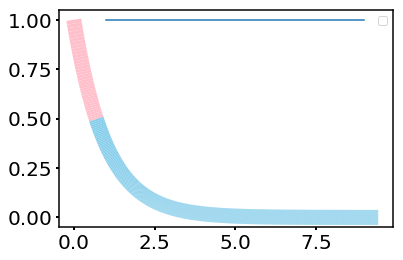

In [922]:

    
x = np.linspace(0, 3 * np.pi, 500)
y = np.exp(-x)

plotTwoColors(x,y,'skyblue','pink',0.5)

plt.plot(np.arange(1,10),[1]*9)
plt.legend()

In [863]:
segments

array([[[0.00000000e+00, 0.00000000e+00],
        [1.88873306e-02, 1.88862077e-02]],

       [[1.88873306e-02, 1.88862077e-02],
        [3.77746612e-02, 3.77656782e-02]],

       [[3.77746612e-02, 3.77656782e-02],
        [5.66619917e-02, 5.66316770e-02]],

       ...,

       [[9.36811597e+00, 5.66316770e-02],
        [9.38700330e+00, 3.77656782e-02]],

       [[9.38700330e+00, 3.77656782e-02],
        [9.40589063e+00, 1.88862077e-02]],

       [[9.40589063e+00, 1.88862077e-02],
        [9.42477796e+00, 3.67394040e-16]]])

C:\Users\Zhaodong Chu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


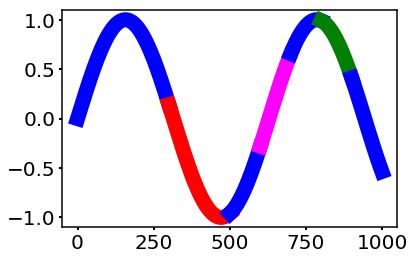

In [874]:
import matplotlib.pyplot as plt
import numpy as np
 
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure()
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start:end],y[start:end],lw=2,c=seg[0]) 
        start = end
        
x = np.arange(1000) 
y = np.sin(x/100) # randomly generated values
# color segments
colors = ['blue']*1000
colors[300:500] = ['red']*200
colors[800:900] = ['green']*100
colors[600:700] = ['magenta']*100
 
plot_multicolored_lines(x,y,colors)
plt.show()


In [27]:
np.random.shuffle(t1_G_std)

(1.0, 6.0731399050702715)

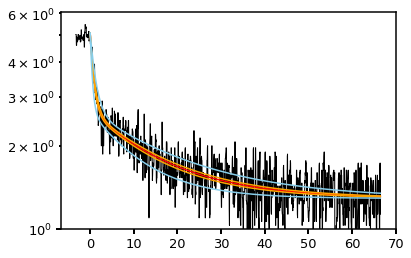

In [34]:
cutoff = 65-0
ind=0.
num_points = 1400
unit_time = 50
offsetdiv=np.inf
normalized=data_Blist[0]
xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(normalized)],normalized[cutoff:])
# fast_list.append(np.min(popt_new[2:4]))
# slow_list.append(np.max(popt_new[2:4]))
plt.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*popt_new)-popt_new[-1]/offsetdiv,color='red',linewidth=1.5)
plt.plot(xlist[:len(normalized)]/1e3,normalized[:]-popt_new[-1]/offsetdiv,'-',linewidth=1,color='black',zorder=-9)

plt.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*[popt_new[0],popt_new[1],popt_new[2]-perr_new[2],popt_new[3]-perr_new[3],popt_new[4]])-popt_new[-1]/offsetdiv,color='orange',linewidth=1.5)
plt.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*[popt_new[0],popt_new[1],popt_new[2]+perr_new[2],popt_new[3]+perr_new[3],popt_new[4]])-popt_new[-1]/offsetdiv,color='orange',linewidth=1.5)

delta = 5
plt.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*[popt_new[0],popt_new[1],popt_new[2]-delta*perr_new[2],popt_new[3]-delta*perr_new[3],popt_new[4]])-popt_new[-1]/offsetdiv,color='skyblue',linewidth=1.5)
plt.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*[popt_new[0],popt_new[1],popt_new[2]+delta*perr_new[2],popt_new[3]+delta*perr_new[3],popt_new[4]])-popt_new[-1]/offsetdiv,color='skyblue',linewidth=1.5)

plt.yscale('log')
plt.ylim(1e0,None)

In [17]:
popt_new

array([1.37648416e+00, 2.42487426e+00, 1.59027670e+04, 8.69188871e+02,
       1.29195447e+00])

In [20]:
perr_new

array([4.21766350e-02, 1.09688307e-01, 9.88362795e+02, 7.29485353e+01,
       1.68521789e-02])